# Optional Lab - Simple Neural Network
In this lab we will build a small neural network using **_PyTorch_**.
   <center> <img  src="./images/C2_W1_CoffeeRoasting.png" width="400" />   <center/>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

import torch
from torch import nn

from lab_utils_common import dlc
from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit

import logging


## DataSet

In [2]:
X, Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


Let's plot the coffee roasting data below. The two features are Temperature in Celsius and Duration in minutes. [Coffee Roasting at Home](https://www.merchantsofgreencoffee.com/how-to-roast-green-coffee-in-your-oven/) suggests that the duration is best kept between 12 and 15 minutes while the temp should be between 175 and 260 degrees Celsius. Of course, as temperature rises, the duration should shrink. 

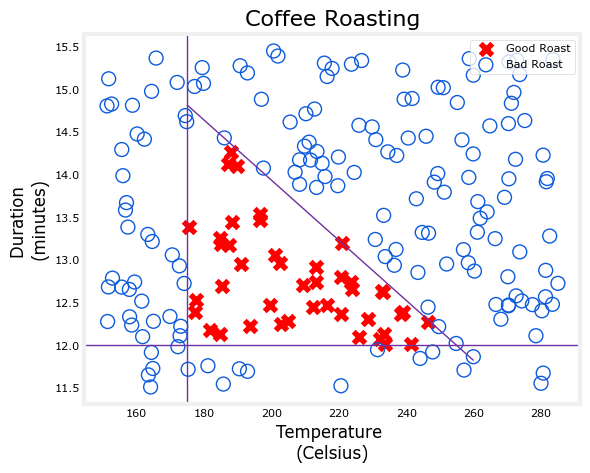

In [3]:
plt_roast(X,Y)

### Normalize Data
Fitting the weights to the data (back-propagation, covered in next week's lectures) will proceed more quickly if the data is normalized. This is the same procedure you used in Course 1 where features in the data are each normalized to have a similar range. 
The procedure below uses a custom normalization function over a torch tensor. It has the following steps:
- Convert numpy arrays to torch tensors.
- Compute mean and standard deviation
- normalize the data.  
It is important to apply normalization to any future data that utilizes the learned model, for which we will need the mean and std

In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
X = torch.tensor(X, dtype=torch.float32, device=device)
Y = torch.tensor(Y, dtype=torch.float32, device=device)

# Compute mean and standard deviation
mean = X.mean(dim=0, keepdim=True)
std = X.std(dim=0, keepdim=True)

# Normalize function
def normalize(x, mean, std):
    return (x - mean) / std

# normalize X
Xn = normalize(X, mean, std)

In [6]:
print(f"Temperature Max, Min pre normalization: {X[:, 0].max()}, {X[:, 0].min()}")
print(f"Duration    Max, Min pre normalization: {X[:, 1].max()}, {X[:, 1].min()}")

print(f"Temperature Max, Min post normalization: {Xn[:, 0].max()}, {Xn[:, 0].min()}")
print(f"Duration    Max, Min post normalization: {Xn[:, 1].max()}, {Xn[:, 1].min()}")

Temperature Max, Min pre normalization: 284.9943542480469, 151.32371520996094
Duration    Max, Min pre normalization: 15.454206466674805, 11.512746810913086
Temperature Max, Min post normalization: 1.6555992364883423, -1.680999755859375
Duration    Max, Min post normalization: 1.7887517213821411, -1.6954150199890137


Tile/copy our data to increase the training set size and reduce the number of training epochs.

In [7]:
Xt = Xn.repeat(1000, 1)
Yt = Y.repeat(1000, 1)
print(Xt.shape, Yt.shape)

torch.Size([200000, 2]) torch.Size([200000, 1])


## PyTorch Model

### Model
   <center> <img  src="./images/C2_W1_RoastingNetwork.PNG" width="200" />   <center/>  
Let's build the "Coffee Roasting Network" described in lecture. There are two layers with sigmoid activations as shown below:

### Forward Prop in PyTorch
<center> <img  src="./images/C2_W1_RoastingNetwork.PNG" width="200" />   <center/>  
Let's build the "Coffee Roasting Network" described in lecture. There are two layers with sigmoid activations.

We can construct the desired neural network architecture we defined in TensorFlow and Numpy using PyTorch.

<img src="images/C2_W1_dense2.PNG" width="600" height="450">

Since this section is focused on **forward propagation**, we will not be training the model. Thus, we will use the weights from the model we trained on TensorFlow. 

We will cover training in the next section. 

In [8]:
torch.manual_seed(1234)  # applied to achieve consistent results
torch.cuda.manual_seed(1234)  # applied to achieve consistent results

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_sigmoid_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=3),
            nn.Sigmoid(),
            nn.Linear(in_features=3, out_features=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.linear_sigmoid_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

# Manually set weights and biases (only do forward propagation)
# Manually setting the weights and biases
W1_tmp = np.array([[-8.93,  0.29, 12.9], [-0.1,  -7.32, 10.81]])
b1_tmp = np.array([-9.82, -9.28,  0.96])
W2_tmp = np.array([[-31.18], [-27.59], [-32.56]])
b2_tmp = np.array([15.41])

with torch.no_grad():
    model.linear_sigmoid_stack[0].weight = nn.Parameter(torch.tensor(W1_tmp, dtype=torch.float32).T.to(device))  # Transpose for correct shape
    model.linear_sigmoid_stack[0].bias = nn.Parameter(torch.tensor(b1_tmp, dtype=torch.float32).to(device))
    model.linear_sigmoid_stack[2].weight = nn.Parameter(torch.tensor(W2_tmp, dtype=torch.float32).T.to(device))  # Transpose for correct shape
    model.linear_sigmoid_stack[2].bias = nn.Parameter(torch.tensor(b2_tmp, dtype=torch.float32).to(device))


NeuralNetwork(
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=3, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


### Predictions
<img align="left" src="./images/C2_W1_RoastingDecision.PNG"     style=" width:380px; padding: 10px 20px; " >

Once you have a trained model, you can then use it to make predictions. Recall that the output of our model is a probability. In this case, the probability of a good roast. To make a decision, one must apply the probability to a threshold. In this case, we will use 0.5

In PyTorch we can do that with Softmax operation + thresholding.

In [9]:
def my_predict(model, x):
    with torch.no_grad():
        return model(x)

In [10]:
X_tst = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_tst = torch.tensor(X_tst, dtype=torch.float32, device=device)
X_tstn = normalize(X_tst, mean, std)  # remember to normalize

predictions_proba = my_predict(model, X_tstn)
predictions_proba

tensor([[9.7116e-01],
        [3.2923e-08]], device='cuda:0')

In [11]:
(predictions_proba > 0.5).int()

tensor([[1],
        [0]], device='cuda:0', dtype=torch.int32)

In [12]:
(predictions_proba.cpu().numpy() > 0.5).astype(int)

array([[1],
       [0]])

## Network function

This graph shows the operation of the whole network and is identical to the Tensorflow result from the previous lab.
The left graph is the raw output of the final layer represented by the blue shading. This is overlaid on the training data represented by the X's and O's.   
The right graph is the output of the network after a decision threshold. The X's and O's here correspond to decisions made by the network.  

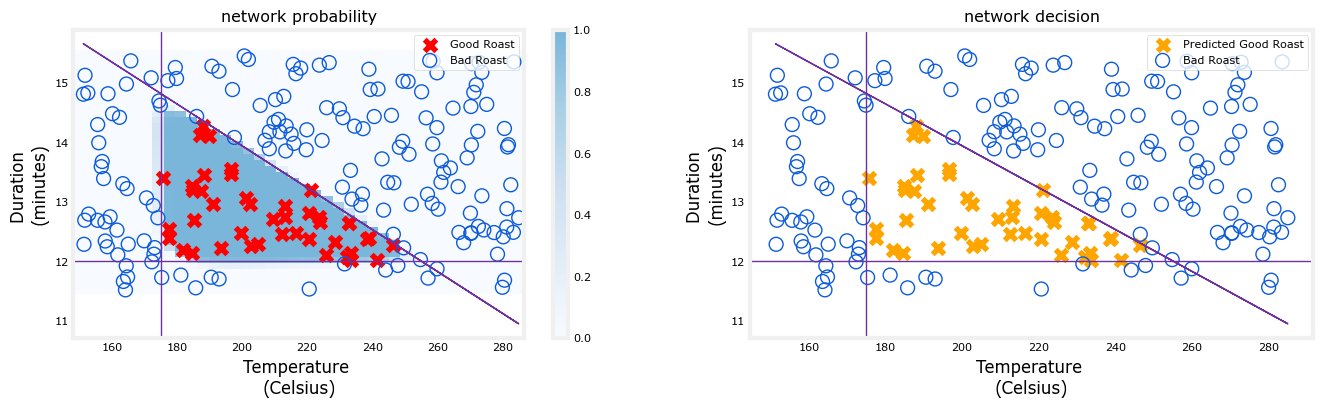

In [25]:
netf = lambda x : my_predict(model, normalize(x, mean, std)).cpu().numpy()
plt_network(X, Y, netf)

## Congratulations!
You have built a small neural network in PyTorch. 
The network demonstrated the ability of neural networks to handle complex decisions by dividing the decisions between multiple units.